## Integrantes:
1. Camila Coltriani
2. Luis Dartayet
3. Irania Fuentes
4. Jonathan Fichelson
5. Ornella Cevoli
# Trabajo práctico 2 : Modelo de regresión lineal del dataset Properatti
## Objetivos
El objetivo de este trabajo final es generar y comparar estadísticamente tres modelos de regresión lineal sobre el dataset limpio de Properatti construido en el TP_1; en este, fue planteado la hipótesis que el precio (variable objetivo) de las propiedades iba a estar influenciado principalmente por la superficie y la ubicación (variables predictoras). 

Con base a esto, se han planteado los siguientes objetivos específicos:
- Explorar el dataset limpio con la finalidad de verificar si debe realizarse una ultima limpieza o pueden utilizase los datos directamente;
- Realizar una visualización general de las distribuciones y relaciones del dataset con la finalidad de determinar la zona, tipo de inmueble y variables predictoras y objetivo para la realización de los modelos;
- Construir modelos de regresión lineal simple y multiple e interpretar sus metricas con la finalidad de identificar el que mejor permita obtener una predicción confiable de la variable objetivo;
- Implementar un modelo de regularización con la finalidad de compararlos y evaluar si existe o no problemas de sobreajuste;
- Determinar el modelo que más se ajusta al comportamiento de los datos analizados. 

In [182]:
#Las librerías utilizadas en este documento son:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn import metrics
from matplotlib.ticker import ScalarFormatter
from matplotlib import gridspec
sns.set()

## Visualización del dataset

In [183]:
# Visualización de la forma y atributos del dataset
data = pd.read_csv("./data/data_limpio_gdf.csv")
print(data.shape)
print("El dataset está compuesto por:", data.shape[0], "filas y",data.shape[1],"columnas.")
data.sample(5)

(45439, 15)
El dataset está compuesto por: 45439 filas y 15 columnas.


,municipio,provincia,lat,lon,sup_m2_total,precio_usd,tipo,ambientes_cat,precio_usd_por_m2,tipo_cat_code,municipio_cat_code,provincia_cat_code,ambientes_cat_code,geometry,precio_usd_por_m2_cat
36610,San Isidro,Bs.As. G.B.A. Zona Norte,-34.460564,-58.517970,1259.0,3300000.0,house,4 o mas,2621.127879,2,303,0,4,POINT (-58.5179705 -34.46056420000001),6
5485,Recoleta,Capital Federal,-34.586665,-58.398186,168.0,475000.0,apartment,4 o mas,2827.380952,1,266,5,4,POINT (-58.3981859 -34.586664899999995),7
36272,Lomas de Zamora,Bs.As. G.B.A. Zona Sur,-34.783080,-58.404445,330.0,289000.0,house,4 o mas,875.757576,2,168,2,4,POINT (-58.4044451 -34.7830798),0
32913,Escobar,Bs.As. G.B.A. Zona Norte,-34.446609,-58.729412,252.0,358000.0,house,4 o mas,1420.634921,2,100,0,4,POINT (-58.729412 -34.446609),2
31097,Recoleta,Capital Federal,-34.588881,-58.395254,92.0,280000.0,apartment,3,3043.478261,1,266,5,3,POINT (-58.39525379999999 -34.5888809),8


### Descripción de las columnas del dataset limpio:

Las columnas que incluye son:

● municipio: ubicación del inmueble por su municipio/barrios

● provincia: ubicación del inmueble por provincia

● lat  ●lon: ubicación de latitud y longitud

● superficie_m2_total: superficie total en m² del inmueble

● price_usd: Precio en dólares del inmueble

● tipo: tipo de inmueble en venta (casa, departamento, ph, tienda)

● ambientes_cat: cantidad de ambientes del inmueble (0, 1, 2, 3 , 4 o más)

● precio_usd_por_m2: Precio en dólares por metro cuadrado (USD/m²: precio dólares / superficie)

● tipo_cat_code: categoría numérica de tipo de inmueble

● municipio_cat_code: categoría numérica de municipios

● provincia_cat_code: categoría numérica de provincia

● tipo_cat_code: categoría numérica de ambientes_cat

● geometry: figura geométrica de latitud y la longitud

● country_name: nombre del país donde ocurre la operación inmobiliaria

● **precio_usd_por_m2_cat: categoría numérica de precio_usd_por_m2**
# Análisis exploratorio y visualización de correlaciones entre las variables

In [184]:
#Revisamos la presencia de datos NaN
data.isna().sum().sort_values()
#La columna "ambientes_cat" quedó con 1248 registros nulos

municipio                   0
provincia                   0
lat                         0
lon                         0
sup_m2_total                0
precio_usd                  0
tipo                        0
precio_usd_por_m2           0
tipo_cat_code               0
municipio_cat_code          0
provincia_cat_code          0
ambientes_cat_code          0
geometry                    0
precio_usd_por_m2_cat       0
ambientes_cat            1248
dtype: int64

In [185]:
missing_by_row=data.isna().sum().sort_values(ascending=False)[0:6]
missing_by_row

ambientes_cat    1248
municipio           0
provincia           0
lat                 0
lon                 0
sup_m2_total        0
dtype: int64

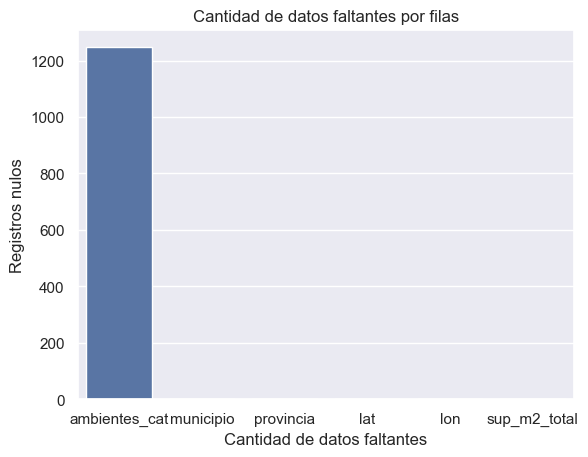

In [186]:
#se realiza lo siguiente solo a fines de graficar 
missing_by_row=data.isna().sum().sort_values(ascending=False)[0:6]
#se grafica cantidad de datos faltantes por fila del data set a fines practicos se visualizan solo las primeras 5 filas
sns.barplot(x=missing_by_row.index, y=missing_by_row.astype(int)) 
plt.title("Cantidad de datos faltantes por filas")
plt.xlabel("Cantidad de datos faltantes")
plt.ylabel("Registros nulos")
plt.show()


In [187]:
#reviso donde están ubicados y a que propiedad pertenecen los registros nulos para saber si afectaran escoger un tipo de inmueble y su zona
mascara_nulos = data["ambientes_cat"].astype(str) == "nan" 
data_nulos = data[mascara_nulos]
data_nulos.loc[:, ["municipio", 'tipo', 'ambientes_cat', "precio_usd"]].sample(7)
#print(data[mascara_nulos].index)

,municipio,tipo,ambientes_cat,precio_usd
21908,La Matanza,house,NaN,170000.00
32511,Villa Crespo,store,NaN,230000.00
7987,Rosario,apartment,NaN,84125.51
3288,La Matanza,house,NaN,80000.00
4747,Córdoba,apartment,NaN,40380.24
15708,Rosario,apartment,NaN,171447.80
29232,San Bernardo,house,NaN,52000.00


C:\Users\ornel\AppData\Local\Temp\ipykernel_9800\1765873710.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(missing_by_row_2.index, rotation=90)


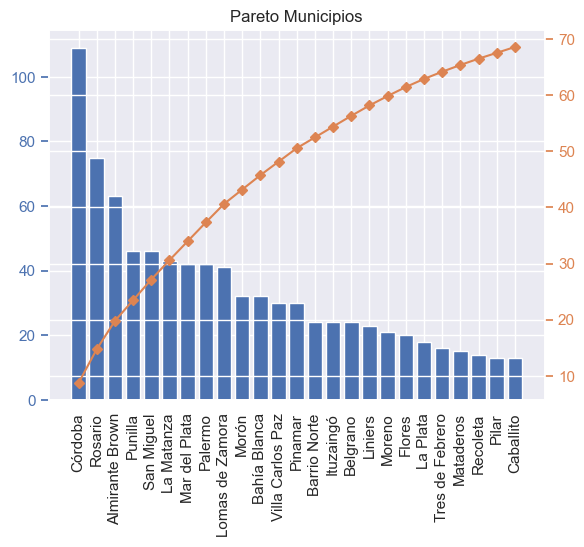

In [188]:
#se realiza lo siguiente solo a fines de graficar en presentacion.
missing_by_row_2= data_nulos.groupby('municipio')['tipo'].count().sort_values(ascending=False).head(25)
missing_by_row_2_porc= missing_by_row_2/data['ambientes_cat'].isna().sum()*100
pareto=missing_by_row_2_porc.values
acum=[]
val_acum=0
for i in missing_by_row_2_porc:
    val_acum= val_acum+i
    acum.append(val_acum)
pareto=acum
pareto
# print(data['municipio'].unique().shape)

# #Revisamos la distribución de los nulos por municipio
fig=plt.figure()
ax= fig.add_subplot(1,1,1)
ax.set_title('Pareto Municipios')
ax.bar(missing_by_row_2.index, missing_by_row_2, color="C0")
ax2=ax.twinx()
ax2.plot(missing_by_row_2.index,pareto,color="C1",marker="D",ms=5)
# ax2.yaxis.set_major_formatter(PercentFormatter(2))
ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
ax.set_xticklabels(missing_by_row_2.index, rotation=90)

plt.show()


In [189]:
#agrupamos los registros donde hay nulos (solo para explicar que no tiene impacto la eliminación de los registros)
pd.options.display.max_rows = None
data_nulos.groupby(["tipo"])["municipio"].value_counts().sort_values(ascending=False)
#vemos que los nan están distribuidos equitativamente y no están concentrados en una mismo municipio

tipo       municipio                          
apartment  Córdoba                                73
           Rosario                                56
house      Almirante Brown                        55
apartment  Palermo                                33
house      Punilla                                29
           Córdoba                                28
store      Mar del Plata                          28
house      Lomas de Zamora                        26
           San Miguel                             26
           Ituzaingó                              22
           La Matanza                             21
           Morón                                  21
apartment  Villa Carlos Paz                       21
           Barrio Norte                           19
           Belgrano                               18
           Pinamar                                17
           San Miguel                             17
house      Bahía Blanca                           15

In [190]:
#Los elimino 
data.dropna(subset=['ambientes_cat'], inplace=True)
print(data.isna().sum())

municipio                0
provincia                0
lat                      0
lon                      0
sup_m2_total             0
precio_usd               0
tipo                     0
ambientes_cat            0
precio_usd_por_m2        0
tipo_cat_code            0
municipio_cat_code       0
provincia_cat_code       0
ambientes_cat_code       0
geometry                 0
precio_usd_por_m2_cat    0
dtype: int64


In [191]:
data.describe()
#existen datos que no permiten ver los estadísticos ya que hay valores de 0 en sup_m2_total e inf en precio_usd_por_m2: eliminarlos

,lat,lon,sup_m2_total,precio_usd,precio_usd_por_m2,tipo_cat_code,municipio_cat_code,provincia_cat_code,ambientes_cat_code,precio_usd_por_m2_cat
count,44191.000000,44191.000000,44191.000000,4.419100e+04,4.419100e+04,44191.000000,44191.000000,44191.000000,44191.000000,44191.000000
mean,-34.785068,-59.026417,105.113575,2.209563e+05,inf,1.239234,196.639225,5.586386,2.601480,4.525899
std,1.837082,2.031306,215.745400,3.174576e+05,NaN,0.608211,115.563981,5.823010,1.158737,2.849106
min,-54.806598,-71.665143,0.000000,1.000000e+01,1.176471e-01,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-34.659264,-58.576770,42.000000,8.600000e+04,1.450440e+03,1.000000,100.000000,3.000000,2.000000,2.000000
50%,-34.603594,-58.455215,66.000000,1.350000e+05,2.047619e+03,1.000000,199.000000,5.000000,3.000000,5.000000
75%,-34.553173,-58.387126,122.000000,2.400000e+05,2.812500e+03,2.000000,276.000000,5.000000,4.000000,7.000000
max,-23.137164,-54.580727,30000.000000,1.200000e+07,inf,3.000000,399.000000,27.000000,4.000000,9.000000


In [192]:
#eliminamos del dataset los registros de sup_m2_total con valores de cero
data.drop(data[(data["sup_m2_total"] ==0)].index, inplace=True ,axis=0)

In [193]:
#Realizamos una descripción estadística del dataset
data.describe()
#Puede observarse mejor los estadisticos media, desv estandar y los minimos y maximos

,lat,lon,sup_m2_total,precio_usd,precio_usd_por_m2,tipo_cat_code,municipio_cat_code,provincia_cat_code,ambientes_cat_code,precio_usd_por_m2_cat
count,44163.000000,44163.000000,44163.000000,4.416300e+04,4.416300e+04,44163.000000,44163.000000,44163.000000,44163.000000,44163.000000
mean,-34.785448,-59.026233,105.180219,2.210394e+05,3.201985e+03,1.239363,196.590540,5.582818,2.602292,4.523062
std,1.837280,2.031694,215.797543,3.175383e+05,2.292673e+04,0.608365,115.574172,5.816332,1.158479,2.847780
min,-54.806598,-71.665143,1.000000,1.000000e+01,1.176471e-01,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-34.659311,-58.576394,42.000000,8.600000e+04,1.450000e+03,1.000000,100.000000,3.000000,2.000000,2.000000
50%,-34.603594,-58.455138,66.000000,1.350000e+05,2.046512e+03,1.000000,198.000000,5.000000,3.000000,5.000000
75%,-34.553225,-58.387121,122.000000,2.400000e+05,2.812500e+03,2.000000,276.000000,5.000000,4.000000,7.000000
max,-23.137164,-54.580727,30000.000000,1.200000e+07,2.600000e+06,3.000000,399.000000,27.000000,4.000000,9.000000


In [194]:
#graficamos las provincias y municipios que contengan un valor mínimo de 500 registros por municipio (para una mejor visualización)
limite = 500
data = data.copy().groupby(['municipio']).filter(lambda grp: grp.shape[0] > limite)

c:\Users\ornel\anaconda3\envs\DH\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


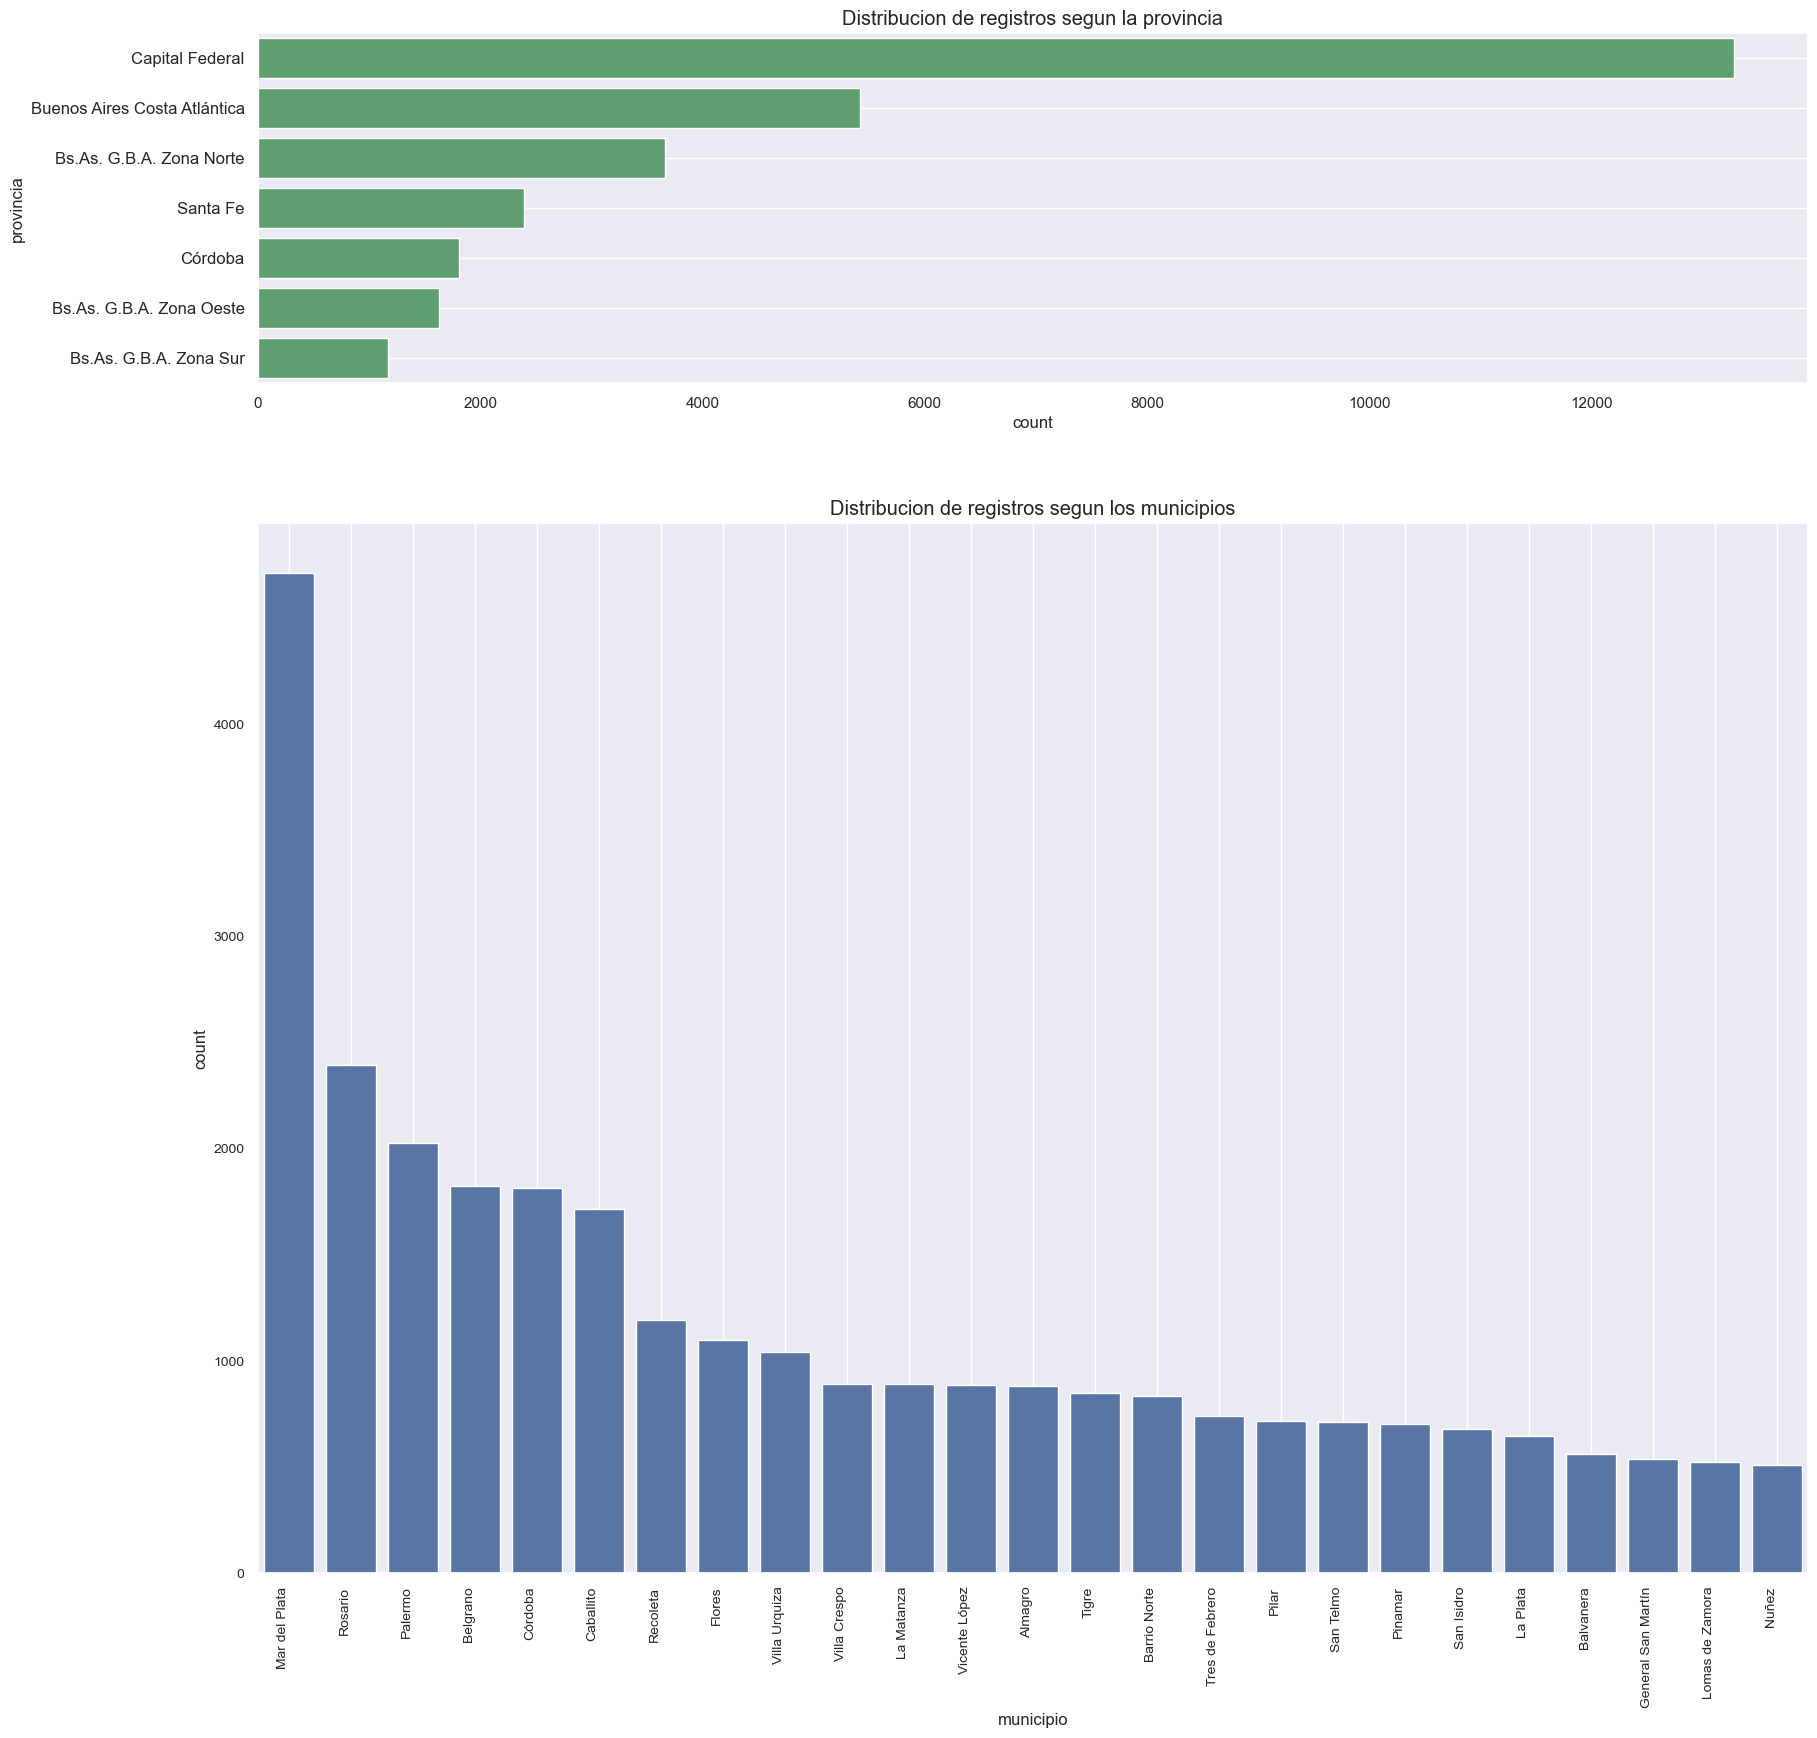

In [195]:
fig= plt.subplots(figsize=(20,20),constrained_layout=True)
grid = gridspec.GridSpec(2, 1, height_ratios=[1, 3])

ax1=plt.subplot(grid[0])
sns.countplot(data=data,y="provincia",order=data["provincia"].value_counts().index ,ax=ax1,color="g")

ax1.set_yticklabels(ax1.get_yticklabels(),fontsize="medium")
ax1.set_title("Distribucion de registros segun la provincia", fontsize= 'large')

ax2=plt.subplot(grid[1])
sns.countplot(data=data,x="municipio",order=data["municipio"].value_counts().index,ax=ax2,color="b")


ax2.set_title("Distribucion de registros segun los municipios", fontsize= 'large')
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90,ha="right")
plt.xticks(fontsize= 10)
plt.yticks(fontsize= 10)
ax1.grid()
ax2.grid()
plt.show()

La mayor cantidad de registros están Capital Federal para los barrios de Palermo, Belgrano, Caballito.
Consideraremos Capital Federal para la evaluación de los modelos 

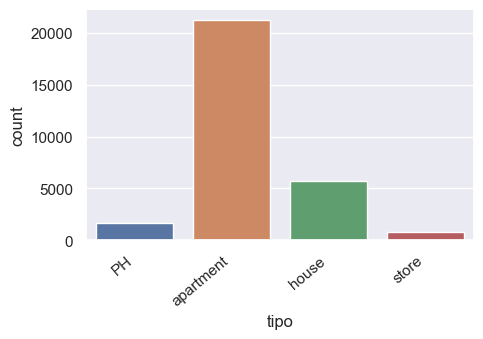

In [196]:
#Revisamos la distribución de registros por tipo de inmueble
plt.figure(figsize=(5,3))

plt.gca().yaxis.set_major_formatter(ScalarFormatter())
ax = sns.countplot(data = data, x = "tipo")
ax.set_xticklabels(ax.get_xticklabels(),rotation=40,ha="right")
plt.show()

#Apartamentos tiene la mayoría de los datos

Apartamentos puede ser una buena eleccion para la evaluacion de los modelos

In [197]:
#armamos un dataset nuevo seleccionando capital federal y apartamentos
data=data.copy()
condicion_provincia= data["provincia"]=="Capital Federal"
condicion_tipo= data["tipo"]== 'apartment'
condicion_compuesta= condicion_provincia&condicion_tipo
data = data[condicion_compuesta]

## Correlación entre la variables del dataset

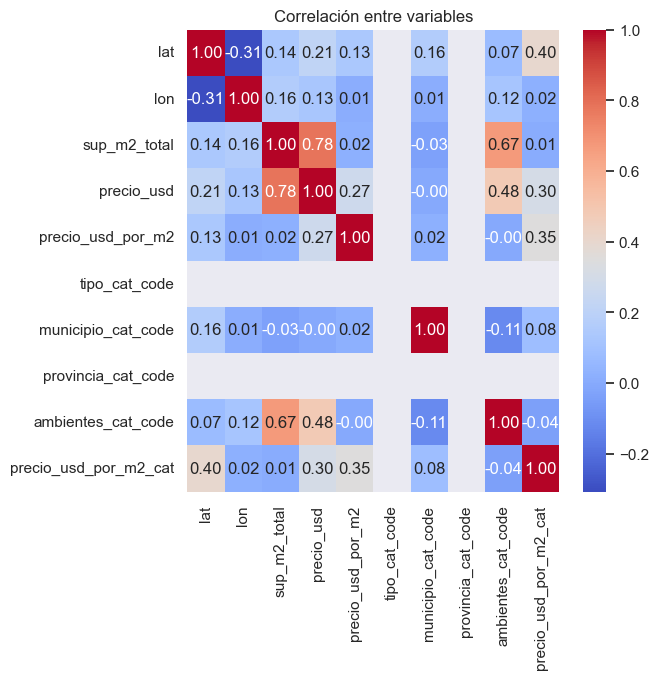

In [198]:
#Vemos la correlación entre las variables 
data_corr = data.corr()
#graficamos
plt.figure(figsize=(6,6))
sns.heatmap(data_corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlación entre variables")
plt.show()


De este cuadro podemos detectar una correlación significativa entre:
*precio_usd y sup_m2_total
*precio_usd y ambientes_cat_code
#precio_usd y lat
variables que utilizaremos para las predicciones

<Figure size 640x480 with 0 Axes>

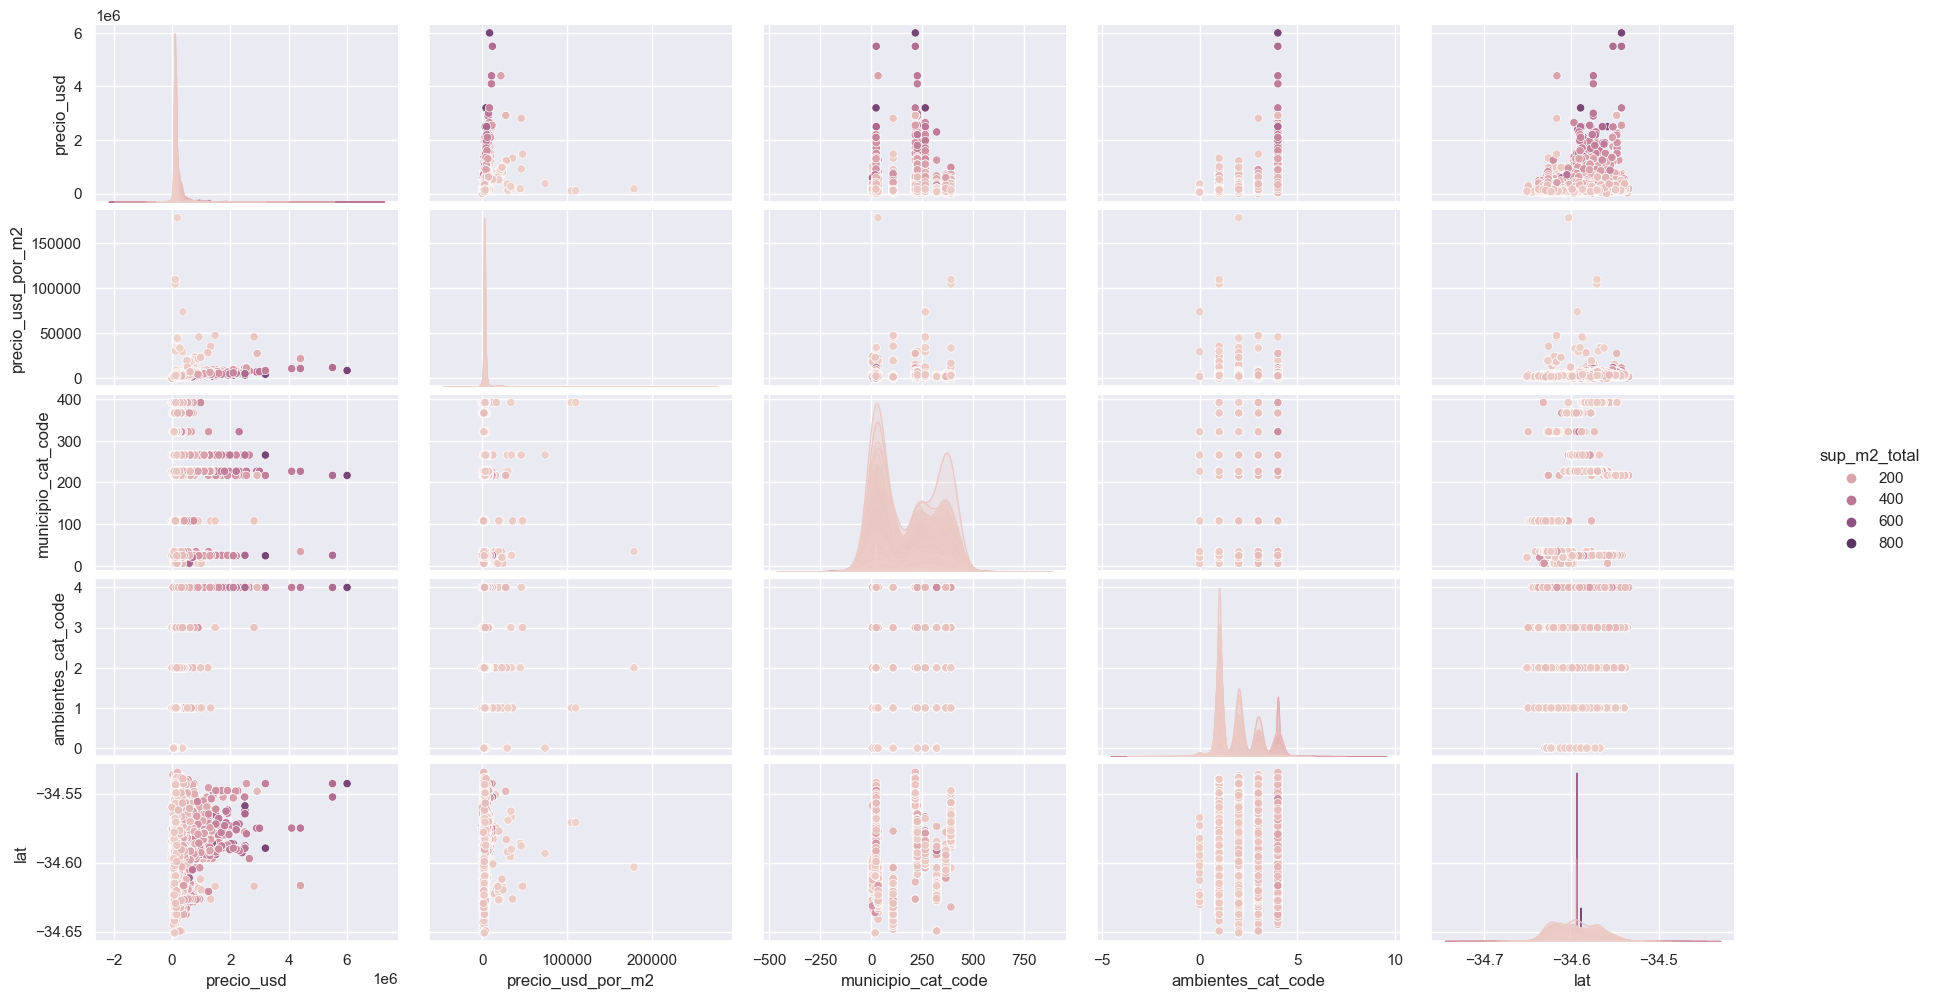

In [199]:
#analizamos la correlación entre cada una de las variables.
figz= plt.figure()
mask_cols= ["sup_m2_total","precio_usd","precio_usd_por_m2", "ambientes_cat", "municipio_cat_code", "ambientes_cat_code","lat"]
graph=sns.pairplot(data[mask_cols],hue="sup_m2_total")
graph.fig.set_size_inches(20,10)
plt.grid()
plt.show()


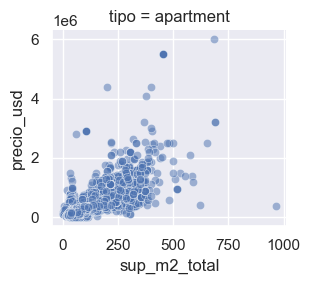

In [200]:
# Realizamos los siguientes gráficos para visualizar mejor (zoom) las relaciones- En primera medida analizamos metros totales con precio en dolares
g = sns.FacetGrid(data, col="tipo")
g.map(sns.scatterplot, "sup_m2_total", "precio_usd", alpha=.5)
g.add_legend()


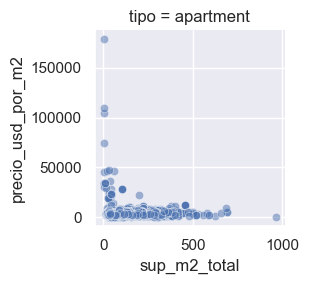

In [201]:
g = sns.FacetGrid(data, col="tipo")
g.map(sns.scatterplot, "sup_m2_total", "precio_usd_por_m2", alpha=.5)
g.add_legend()

De estos dos graficos vemos mejor relacion entre sup_m2_total y precio_usd por lo cual utilizaremos estas dos variables para predecir

Ademas se puede detectar un outlier que podria impactar sobre las predicciones en la variable Superficie para valores mayores a 965m2 y para precios 4x10e6

In [202]:
#detectamos el valor maximo de superficie total
data["sup_m2_total"].max()

965.0

In [203]:
#eliminamos los outliers
data.drop(data[(data["sup_m2_total"]>=965)].index, inplace=True ,axis=0)

In [204]:
#corroboramos que se eliminó
data["sup_m2_total"].max()

690.0

In [205]:
data.shape

(11756, 15)

In [206]:
#eliminamos outliers para valores de propiedades mayores a 4M usd
outliers_precios= data["precio_usd"]>=4000000
data.drop(data[outliers_precios].index, inplace=True ,axis=0)

In [207]:
#corroboro que elimino los outliers
data.shape

(11747, 15)

Conclusiones del análisis de variables predictoras y target:
- La mayor cantidad de registros están Capital Federal.
- Utilizaremos departamentos como el tipo de inmueble a modelar por contener una mayor cantidad de datos
- Consideraremos como variables predictora Superficie total y variable objetivo precio usd por su alta correlación, y su distribución. Luego evaluaremos el impacto de las variables de ubicación y ambientes.


## Regresión lineal simple

Analizaremos la relacion existente entre la variable objetivo precio total en dolares y su feature la superficie total

In [208]:
#preparamos la matriz de features y target
X = data[['sup_m2_total']]
y = data['precio_usd']

# Instanciamos el modelo.
lm = linear_model.LinearRegression()

# Dividimos el dataset en train y test
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Ajustamos el modelo a los datos de entrenamiento
model = lm.fit(Xtrain, ytrain)

# Predecimos etiquetas para datos desconocidos.
y_pred = lm.predict(Xtest)


In [209]:
# Imprimimos el intercepto y los coeficientes como atributos del objeto entrenado.
print ('Intercepto =', ' ', model.intercept_)
print ('b_sup_m2_total=', ' ', model.coef_)
# imprimimos la métrica que mide la bondad de ajusto del modelo. En este caso el R2.
print("R2_train: ", model.score(Xtrain, ytrain))
print ('R2_test=','', metrics.r2_score(ytest, y_pred))
print ('MSE:', metrics.mean_squared_error(ytest, y_pred))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(ytest, y_pred)))


Intercepto =   -25380.588017384667
b_sup_m2_total=   [3480.39656436]
R2_train:  0.666846217691238
R2_test=  0.6753487330880463
MSE: 19979953631.60448
RMSE: 141350.46385351723


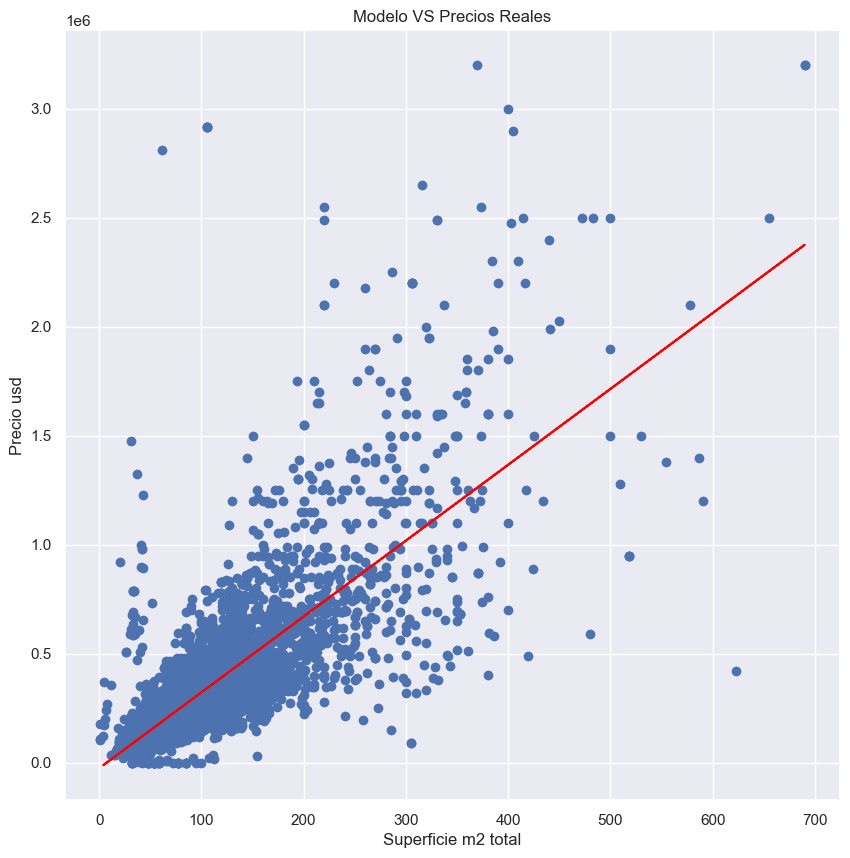

In [210]:
# Graficamos el modelo re regresion del modelo con train_test_split
plt.figure(figsize=(10,10))
plt.plot(Xtest,y_pred,color="red",label="Predict line")
plt.scatter(X,y)
plt.xlabel("Superficie m2 total")
plt.ylabel("Precio usd")
plt.title('Modelo VS Precios Reales')
plt.show()

#REVISAR CONCLUSIONES QUE SEAN ACORDES /// LAS PRESENTES SON LAS ANTERIORES


Resumen de los parametros estadisticos determinados:

El valor promedio de precio cuando la superficie total es cero (intercepto) disminuye en el modelo con train-test-split: 
66921 usd al modelar todos los datos y 55234 usd al hacer la separacion de datos.
Al considerar una menor cantidad de datos que modelando a toda "población" es razonable.

El efecto promedio que tiene sobre precio usd el incremento en una unidad de superficie total aumenta en el modelo con separacion de datos: 1875 unidades al hacer la separacion de datos y aprox 1694 unid al modelar todos los datos

El R2 es la respuesta de que nuestra variable objetivo es explicada por el modelo, por lo que tenemos mejores resultados al testear con una menor cantidad de datos. 

    El R2 de entrenamiento disminuye de 0.41 a 0.39 al hacer la separacion de los datos en train_test_split. 

    El R2 para el test es de 0.43

El error (r_EMC) de test es de 124250. Las predicciones del modelo final se alejan en promedio 124250 unidades del valor real.

En resumen: 
Al separar los datos estamos tomando muestras sobre nuestra poblacion muestral en el cual la muestra evaluada puede dar considerablemente diferente. 

    Al realizar la prueba test se observa que el modelo es capaz de explicar el 43% de la variabilidad observada en la variable precio en usd.

## Regresión lineal múltiple

Agregamos a la correlacion las variables latitud y longitud

In [235]:
# Asignamos las variables predictoras
X = data[['lon','lat', 'sup_m2_total']]
y = data['precio_usd']

# Dividimos en train y test
Xtrain_regmul, Xtest_regmul, ytrain_regmul, ytest_regmul = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizamos los datos
scaler = StandardScaler()
scaler.fit(Xtrain_regmul,ytrain_regmul)
Xscaler = scaler.transform(Xtrain_regmul)

# Instanciamos el modelo y lo entrenamos
lr= linear_model.LinearRegression()
model=lr.fit(Xscaler,ytrain_regmul)


In [244]:
# Predecimos etiquetas para datos desconocidos.
y_pred_regmul = lr.predict(Xtest_regmul.values)

#REVISAR!!!! DA R2 TRAIN NEGATIVO DEBE HABER ERROR DE CALCULO QUE NO ENCUENTRO - despues cuando se hace OLS da valores razonables- quizas hay q borrar esta parte

In [245]:
# Vemos los coeficientes
print('Coeficientes: ', lr.coef_)
print('Intercepto: ', lr.intercept_)
print("R2_train: ", model.score(Xscaler,ytrain_regmul))
print ('R2_test:', metrics.r2_score(ytest_regmul, y_pred_regmul))
print ('MSE:', metrics.mean_squared_error(ytest_regmul, y_pred_regmul))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(ytest_regmul, y_pred_regmul)))

Coeficientes:  [ 14434.83543163  34656.04726621 202082.21300653]
Intercepto:  234536.55334362356
R2_train:  0.6828710116555297
R2_test: -4667.589813513101
MSE: 287318170313101.2
RMSE: 16950462.24482097


In [231]:
rmse_simple= np.sqrt(metrics.mean_squared_error(ytest, y_pred))
rmse_multiple= np.sqrt(metrics.mean_squared_error(ytest_regmul, y_pred_regmul))


In [232]:
print('Diferencia porcentual entre el rmse de la regresión simple y la regresión múltiple: ', (rmse_multiple - rmse_simple)/rmse_simple*100)
print('Diferencia absoluta entre el rmse de la regresión simple y la regresión múltiple: ', rmse_multiple - rmse_simple)

Diferencia porcentual entre el rmse de la regresión simple y la regresión múltiple:  11891.798104311063
Diferencia absoluta entre el rmse de la regresión simple y la regresión múltiple:  16809111.780967455


#REVISAR CONCLUSIONES QUE SEAN ACORDES /// LAS PRESENTES SON LAS ANTERIORES

Recordemos que para la regresión lineal simple, la raíz del error cuadrático medio (RMSE) fue de `r_EMC: 113040.74611014882`, muy similar al RMSE de la regresión lineal múltiple, que es de `r_EMC: 124196.721423661`, una diferencia de `r_EMC: 11155.97531351218` que es del 10% del RMSE de la regresión lineal simple.

Esto nos indica que la regresión lineal múltiple no mejora el modelo, por lo que no es necesario agregar más variables.

Podemos también confirmar que la regresión lineal múltiple no mejora el modelo viendo la no mejora del score de validación cruzada y las correlaciones de las variables.

In [247]:
# Cross validation
scores = cross_val_score(lr, Xtrain_regmul, ytrain_regmul, cv=5)

print('Cross-validated scores:', scores)
print('Cross-validated scores mean:', scores.mean())


Cross-validated scores: [0.7046174  0.72748477 0.69098131 0.65071225 0.65284828]
Cross-validated scores mean: 0.6853288022906459


In [248]:
# Modelamos con statsmodels

X_train_sm = sm.add_constant(Xtrain_regmul)

model = sm.OLS(ytrain_regmul, X_train_sm).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             precio_usd   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     6742.
Date:                Wed, 21 Dec 2022   Prob (F-statistic):               0.00
Time:                        10:47:32   Log-Likelihood:            -1.2496e+05
No. Observations:                9397   AIC:                         2.499e+05
Df Residuals:                    9393   BIC:                         2.500e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         7.929e+07   4.49e+06     17.674   

#REVISAR CONCLUSIONES QUE SEAN ACORDES /// LAS PRESENTES SON LAS ANTERIORES
Comparando la regresión multiple sencilla con la regresión OLS podemos observar como OLS nos permite validar la significancia de los datos obtenidos. Vemos con los p values para las variables latitud y longitud son mayores al nivel de significancia por lo cual estas variables no están explicando o no tiene valor de predicción sobre el valor de nuestra variable objetivo precio en dólares.

Al incluir latitud y longitud disminuye el performance del R2 a 0,38 en la regresión multiple.

## Regularización ridge y lasso

Variables predictoras: latitud, longitud y superficie total

Variable objetivo: precio en usd

Volvemos a presentar las metricas obtenidas en la regresión multiple con OLS para las variables mencionadas para comparar con las metricas obtenidas en Lasso y Ridge

#REVISAR CONCLUSIONES QUE SEAN ACORDES /// LAS PRESENTES SON LAS ANTERIORES


Para un nivel de confianza de 0.05, el p-value del modelo es 0.7007 para la variable latitud por lo que se puede decir que el modelo es peor que lo esperado por el azar para esa variable, el coeficiente parcial de regresión es 0 y no tiene correlación con la varible objetivo.
los p-value de longitud y superficie total (0.043 y 0.000) no están indicando que las variables contribuyen a la preddicción de nuestra variable objetivo. 

Ridge

In [249]:
# Probamos con regularización ridge
lm_ridge = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13))

model_ridge = lm_ridge.fit(Xtrain_regmul, ytrain_regmul)

print ('Modelo Ridge:')
print('hiperparametro alpha: ', model_ridge.alpha_)
print('coeficientes ajustados: ', model_ridge.coef_)
print('intercepto: ', model_ridge.intercept_)
print('R2 train: ', model_ridge.score(Xtrain_regmul, ytrain_regmul))
print('R2 test: ', model_ridge.score(Xtest_regmul, ytest_regmul))

Modelo Ridge:
hiperparametro alpha:  0.01
coeficientes ajustados:  [ 474687.80310269 1484628.71214532    3362.35188325]
intercepto:  79079041.83802368
R2 train:  0.6828709126426252
R2 test:  0.6933617800355176


#REVISAR CONCLUSIONES QUE SEAN ACORDES /// LAS PRESENTES SON LAS ANTERIORES

Este método consigue minimizar la influencia sobre el modelo de los predictores menos relacionados con la variable respuesta disminuyendolos sin llegar a cero.

Vemos como al igual que el modelo OLS también nos indica que la variable latitud está muy poco correlacionada con el precio usd

Existe mayor influencia de la variable superficie total que longitud al explicar la variable precio usd

El valor promedio de la variable objetivo permanece sin mayor cambio en los modelos OLS y LASSO

El R2 de test en Ridge explica el 43% de la variabilidad observada en la variable precio en usd.

Los R2 de train y test son similares e indican que no hay overfitting y las pruebas en test resultan mejores que en train

Lasso

In [250]:
# Probamos con regularización lasso

lm_lasso = linear_model.LassoCV(alphas=np.logspace(-6, 6, 13), cv=5)

model_lasso = lm_lasso.fit(Xtrain_regmul, ytrain_regmul)

print ('Modelo Lasso:')
print('hiperparametro alpha : ', model_lasso.alpha_)
print('coeficientes ajustados: ', model_lasso.coef_)
print('intercepto: ', model_lasso.intercept_)
print('R2 train: ', model_lasso.score(Xtrain_regmul, ytrain_regmul))
print('R2 test: ', model_lasso.score(Xtest_regmul, ytest_regmul))


Modelo Lasso:
hiperparametro alpha :  1e-06
coeficientes ajustados:  [ 476198.19391297 1488257.45886171    3362.05656212]
intercepto:  79292850.68063176
R2 train:  0.6828710116555301
R2 test:  0.6933643165479986


#REVISAR CONCLUSIONES QUE SEAN ACORDES /// LAS PRESENTES SON LAS ANTERIORES

La regularización con Lasso tiene el efecto de forzar a que los coeficientes de los predictores tiendan a cero; un predictor con coeficiente de regresión cero no influye en el modelo, por lo que consigue excluir los predictores que no son relevantes.

En este caso la regularización con lasso no llevó ninguna variable a cero, sin embargo nos sigue mostrando una mejor explicación de precio usd con superficie total principalmente y longitud.

Los R2 de train y test son similares e indican que no hay overfitting y las pruebas en test resultan mejores que en train

### Por último, analizaremos el impacto de la variables ambientes en la predicción de la variable precio. 

    "ver la explicación al final de la sección"

In [251]:
# Creamos las variables dummies para la variable categórica de ambientes
data_ambientes_dummies = pd.get_dummies(data, columns=['ambientes_cat'], drop_first=True)
print(data_ambientes_dummies.shape)
data_ambientes_dummies.head()

(11747, 18)


,municipio,provincia,lat,lon,sup_m2_total,precio_usd,tipo,precio_usd_por_m2,tipo_cat_code,municipio_cat_code,provincia_cat_code,ambientes_cat_code,geometry,precio_usd_por_m2_cat,ambientes_cat_1,ambientes_cat_2,ambientes_cat_3,ambientes_cat_4 o mas
3,Belgrano,Capital Federal,-34.559873,-58.443362,40.0,138000.0,apartment,3450.000000,1,25,5,1,POINT (-58.443362 -34.5598729),8,1,0,0,0
4,Belgrano,Capital Federal,-34.559873,-58.443362,60.0,195000.0,apartment,3250.000000,1,25,5,2,POINT (-58.443362 -34.5598729),8,0,1,0,0
10,Palermo,Capital Federal,-34.580504,-58.405874,96.0,350000.0,apartment,3645.833333,1,227,5,3,POINT (-58.4058744847 -34.580503566),8,0,0,1,0
11,Palermo,Capital Federal,-34.590926,-58.411665,73.0,270500.0,apartment,3705.479452,1,227,5,4,POINT (-58.4116653 -34.590926),8,0,0,0,1
16,Flores,Capital Federal,-34.635118,-58.473964,43.0,75000.0,apartment,1744.186047,1,108,5,2,POINT (-58.4739639408 -34.635117947800005),3,0,1,0,0


In [252]:
# Asignamos las variables predictoras

X_cat = data_ambientes_dummies [['ambientes_cat_1', 'ambientes_cat_2', 'ambientes_cat_3', 'ambientes_cat_4 o mas','sup_m2_total']]
y = data_ambientes_dummies ['precio_usd']

# Normalizamos los datos
scaler = StandardScaler()
scaler.fit(X_cat)
X_cat = scaler.transform(X_cat)
# X_cat

# Dividimos en train y test
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y, test_size=0.2, random_state=42)
#y_test_cat

# Instanciamos el modelo y lo entrenamos
lr_cat = linear_model.LinearRegression()
lr_cat.fit(X_train_cat, y_train_cat)

LinearRegression()

In [253]:
# Vemos los coeficientes

print('Coeficientes: ', lr_cat.coef_)
print('Intercepto: ', lr_cat.intercept_)

# Calculamos el R2
print('R2: ', r2_score(y_test_cat, lr_cat.predict(X_test_cat)))

Coeficientes:  [-13546.04036659 -16060.24154787 -22617.63960676 -23988.43596003
 213729.76475704]
Intercepto:  233462.2720372828
R2:  0.6782377845806087


In [254]:
# Modelamos con statsmodels

X_train_sm_2 = sm.add_constant(X_train_cat)
model_stats = sm.OLS(y_train_cat, X_train_sm_2).fit()

print(model_stats.summary())

                            OLS Regression Results                            
Dep. Variable:             precio_usd   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     3783.
Date:                Wed, 21 Dec 2022   Prob (F-statistic):               0.00
Time:                        19:59:49   Log-Likelihood:            -1.2518e+05
No. Observations:                9397   AIC:                         2.504e+05
Df Residuals:                    9391   BIC:                         2.504e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.335e+05   1522.691    153.322      0.0

In [255]:
# Probamos con regularización ridge

lm_ridge_2 = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13, 20,30))

model_ridge_2 = lm_ridge_2.fit(X_train_cat, y_train_cat)

print(lm_ridge_2.alpha_)
print(lm_ridge_2.coef_)
print(model_ridge_2.score(X_test_cat, y_test_cat))

1.0
[-13142.32244793 -15679.32381468 -22240.46110604 -23569.1316911
 213675.00649439]
0.6782266039813698


In [256]:
# Probamos con regularización lasso

lm_lasso_2 = linear_model.LassoCV(alphas=np.logspace(-6, 6, 13,20,30), cv=5)

model_lasso_2 = lm_lasso_2.fit(X_train_cat, y_train_cat)

print(lm_lasso_2.alpha_)
print(lm_lasso_2.coef_)
print(model_lasso_2.score(X_test_cat, y_test_cat))

1.0
[-13341.29738324 -15869.12413153 -22432.46130618 -23794.1445184
 213724.34932372]
0.6782375896771736


c:\Users\ornel\anaconda3\envs\DH\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5282557626447.984, tolerance: 50273582560.25303
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\ornel\anaconda3\envs\DH\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12487456011491.688, tolerance: 46708466134.00162
  model = cd_fast.enet_coordinate_descent_gram(


#REVISAR RESULTADO XQ DICE Q OBJETIVO NO CONVERGE
#REVISAR CONCLUCIONES LAS PRESENTES CORRESPONDEN A ANALISIS ANTERIOR

Al modelar las categorias ambientes obtenemos:

- OLS: Para un nivel de confianza de 0.05, los p-value del modelo para las variables ambientes (1 a 4+) son mucho mayores al nivel de confianza por lo que se puede inferir que los coeficientes parciales de regresión son iguales a 0 y no tiene correlación con la varible objetivo.

- Ridge:vemos que la influencia sobre el modelo de los predictores ambientes (1 ambiente a 3 ambientes) están muy poco relacionados con la variable respuesta por lo que los vemos disminuidos.

   para mas de 4 ambientes y superficie vemos que existe correlación

- Lasso: vemos que la influencia sobre el modelo de los predictores ambientes (1 ambiente a 2 ambientes) están muy poco relacionados con la variable respuesta por lo que los vemos disminuidos.
   
   No hay influencia de los immuebles de 3 ambientes con la variable precio pues el valor del coeficiente es cero.

   La mayor respuesta para explicar el precio usd de las propiedades es la superficie total